In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [29]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os

import time

# import data class
from utilities.dataset_utils import DiabetesData

from qiskit_machine_learning.algorithms import QSVC

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# explainability imports
from shap import TreeExplainer
from shap import summary_plot
from shap import force_plot
from shap import waterfall_plot

# qiskit imports
# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [30]:
np.random.seed(42)  # reproducibility

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [31]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [32]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'models', 'qml-simulator', 'qsvc_best_params.model')

qsvc = QSVC.load(path)

In [33]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

In [34]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [35]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [36]:
# sampler
sampler = Sampler.from_backend(backend)

In [37]:
samples = len(X_test)
decisions = []
batch_size = 10

for start in range(0, samples, batch_size):
    start_time = time.time()
    end = min(start + batch_size, samples)
    
    remaining_samples = samples - end
    progress = (end / samples) * 100
    
    batch = X_test[start:end]
    
    decisions.append(qsvc.decision_function(batch))
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Processed {end}/{samples} samples ({progress:.2f}%). Remaining: {remaining_samples}. Time: {elapsed_time:.2f}s")
    
decisions = np.concatenate(decisions)

Processed 10/231 samples (4.33%). Remaining: 221. Time: 101.50s
Processed 20/231 samples (8.66%). Remaining: 211. Time: 98.86s
Processed 30/231 samples (12.99%). Remaining: 201. Time: 85.99s
Processed 40/231 samples (17.32%). Remaining: 191. Time: 87.85s
Processed 50/231 samples (21.65%). Remaining: 181. Time: 91.27s
Processed 60/231 samples (25.97%). Remaining: 171. Time: 87.24s
Processed 70/231 samples (30.30%). Remaining: 161. Time: 91.76s
Processed 80/231 samples (34.63%). Remaining: 151. Time: 88.83s
Processed 90/231 samples (38.96%). Remaining: 141. Time: 91.07s
Processed 100/231 samples (43.29%). Remaining: 131. Time: 89.57s
Processed 110/231 samples (47.62%). Remaining: 121. Time: 91.02s
Processed 120/231 samples (51.95%). Remaining: 111. Time: 90.49s
Processed 130/231 samples (56.28%). Remaining: 101. Time: 91.62s
Processed 140/231 samples (60.61%). Remaining: 91. Time: 88.67s
Processed 150/231 samples (64.94%). Remaining: 81. Time: 103.57s
Processed 160/231 samples (69.26%). 

In [38]:
if decisions.ndim != 1 and decisions.shape[1] == 1:
    decisions = decisions.flatten()
    
print(f"Decision function shape: {decisions.shape}")

Decision function shape: (231,)


In [39]:
df_results = pd.DataFrame(X_test, columns=feature_names)
df_results['qsvc_decision'] = decisions
df_results['target'] = y_test # Assumes y_test corresponds to X_test
df_results['predicted_class'] = (decisions > 0).astype(int)

df_results.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,qsvc_decision,target,predicted_class
0,-0.647059,0.306533,0.278689,-0.535354,-0.813239,-0.153502,-0.790777,-0.566667,-1.123641,1,0
1,-0.529412,0.095477,0.049180,-0.111111,-0.765957,0.037258,-0.293766,-0.833333,-0.830809,1,0
2,0.294118,0.437186,0.540984,-0.333333,-0.654846,0.090909,-0.849701,0.000000,0.870671,1,1
3,-0.529412,0.447236,0.344262,-0.353535,-1.000000,0.147541,-0.593510,-0.466667,0.568223,1,1
4,-0.058824,0.055276,0.639344,-0.272727,-1.000000,0.290611,-0.862511,-0.200000,-0.227575,1,0


In [40]:
wrong_preds = df_results[df_results['predicted_class'] != df_results['target']]
X_wrong = X_test[wrong_preds.index]
y_wrong = y_test[wrong_preds.index]
decisions_wrong = decisions[wrong_preds.index]
print(f"\nIdentified {len(wrong_preds)} wrongly classified samples.")

n_wrong_sample = min(50, len(wrong_preds))
if n_wrong_sample > 0:
    wrong_indices = np.random.choice(wrong_preds.index, n_wrong_sample, replace=False)
    X_wrong_sample = X_test[wrong_indices]
else:
    X_wrong_sample = None


Identified 61 wrongly classified samples.


In [41]:
uncertainty_threshold = 0.5 # adjust as needed
uncertain_preds = df_results[np.abs(df_results['qsvc_decision']) < uncertainty_threshold]
X_uncertain = X_test[uncertain_preds.index]
y_uncertain = y_test[uncertain_preds.index]
decisions_uncertain = decisions[uncertain_preds.index]
print(f"Identified {len(uncertain_preds)} uncertain samples (decision |val| < {uncertainty_threshold}).")

n_uncertain_sample = min(50, len(uncertain_preds))
if n_uncertain_sample > 0:
    uncertain_indices = np.random.choice(uncertain_preds.index, n_uncertain_sample, replace=False)
    X_uncertain_sample = X_test[uncertain_indices]
else:
    X_uncertain_sample = None

Identified 52 uncertain samples (decision |val| < 0.5).


In [42]:
X_surrogate_train = X_test
y_surrogate_train = decisions

# Initialize and train the surrogate
surrogate_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
surrogate_model.fit(X_surrogate_train, y_surrogate_train)

# Evaluate how well the surrogate mimics the QSVC on the test data
surrogate_predictions = surrogate_model.predict(X_surrogate_train)
mse = mean_squared_error(y_surrogate_train, surrogate_predictions)
r2 = r2_score(y_surrogate_train, surrogate_predictions)

print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R^2 Score: {r2:.4f}")

# Add surrogate predictions to the results DataFrame
df_results['surrogate_decision'] = surrogate_predictions

  Mean Squared Error: 0.0195
  R^2 Score: 0.9753


In [43]:
explainer_surrogate = TreeExplainer(surrogate_model, data=X_train)

shap_values_surrogate_test = explainer_surrogate.shap_values(X_test, check_additivity=False)

if X_wrong_sample is not None:
    shap_values_surrogate_wrong = explainer_surrogate.shap_values(X_wrong_sample, check_additivity=False)
else:
    shap_values_surrogate_wrong = None

if X_uncertain_sample is not None:
    shap_values_surrogate_uncertain = explainer_surrogate.shap_values(X_uncertain_sample, check_additivity=False)
else:
    shap_values_surrogate_uncertain = None

/tmp/ipykernel_717798/226214612.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot(


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

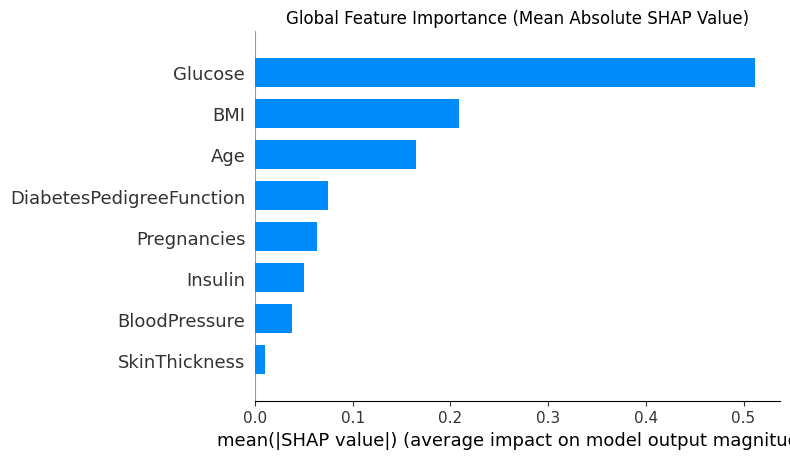

In [44]:
plt.figure()
summary_plot(
    shap_values_surrogate_test,
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_717798/240390534.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot(


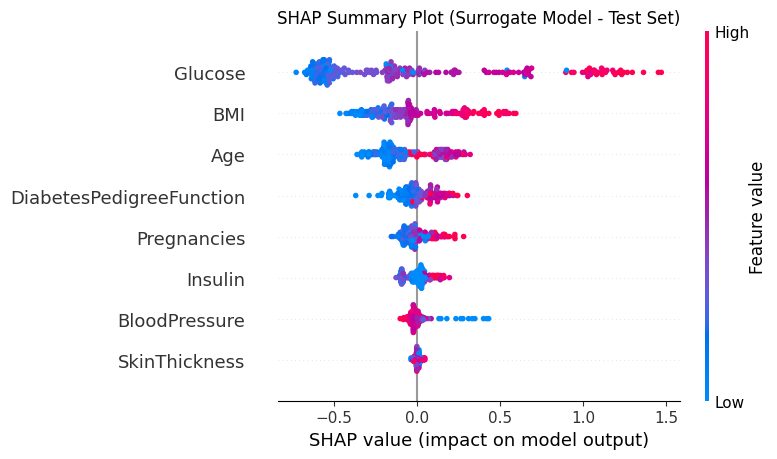

In [45]:
plt.figure()
summary_plot(
    shap_values_surrogate_test,
    X_test,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary Plot (Surrogate Model - Test Set)")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

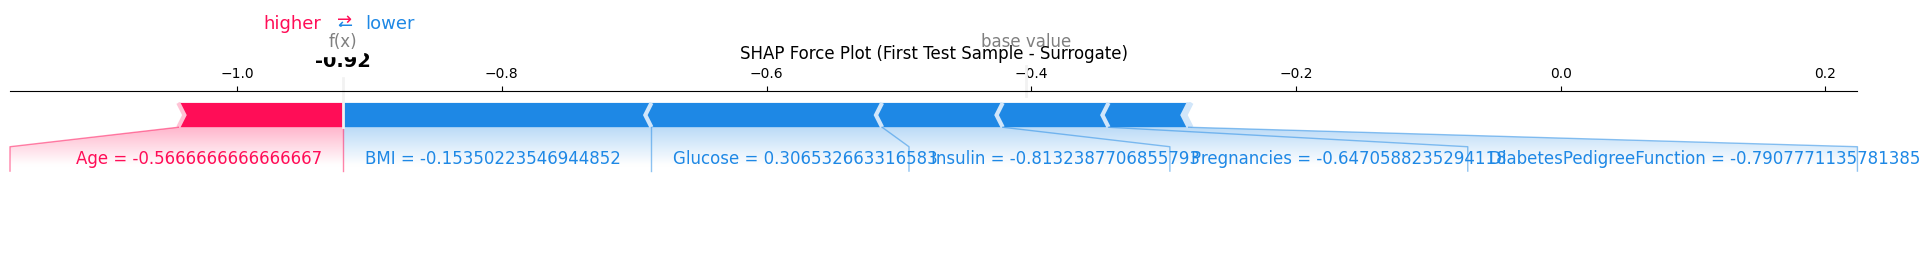

In [46]:
plt.figure()
force_plot(
    explainer_surrogate.expected_value,
    shap_values_surrogate_test[0,:],
    X_test[0,:],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title("SHAP Force Plot (First Test Sample - Surrogate)")
plt.tight_layout()
plt.show()